## Poisson model

In [1]:
#import os,sys

#pymc3_path = os.path.join(os.environ["HOME"], "repos", "lib", "pymc3")
#sys.path.insert(0, pymc3_path)

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from theano import tensor as ts
import pymc3 as pm

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8,6)

In [4]:
#from blaze import Data
#from odo import odo

#t = Data("sqlite:///data.sqlite3::train")
#usecols = ["week_num","agency_id","product_id","adjusted_demand"]
#t = t[usecols]
#t = t.sample(n=200000)
#odo(t, "downloads/test-samp-20k.csv")

In [5]:
train_samp = pd.read_csv("downloads/train-samp-20k.csv")
train_samp.head()

,week_num,agency_id,product_id,adjusted_demand
0,6,1462,43058,5
1,7,22560,1250,4
2,3,2015,1309,3
3,7,2653,42434,4
4,3,1381,1240,28


In [6]:
n_weeks = len(np.unique(train_samp.week_num))
n_agencies = len(np.unique(train_samp.agency_id))
n_products = len(np.unique(train_samp.product_id))

In [7]:
print("Number of weeks: {}\n Number of products: {}\n Number of agencies {}".format(n_weeks,n_products,n_agencies))

Number of weeks: 7
 Number of products: 645
 Number of agencies 485


In [8]:
class Encoder:
    
    def __init__(self):
        self._week_le = LabelEncoder()
        self._agency_le = LabelEncoder()
        self._product_le = LabelEncoder()
    
    def transform(self, df):
        week_code = self._week_le.fit_transform(df.week_num)
        agency_code = self._agency_le.fit_transform(df.agency_id)
        product_code = self._product_le.fit_transform(df.product_id)
        return week_code, agency_code, product_code

le = Encoder()

In [9]:
week_code, agency_code, product_code = le.transform(train_samp)

In [10]:
train_samp.adjusted_demand.describe()

count    20000.000000
mean         7.439350
std         22.302163
min          0.000000
25%          2.000000
50%          3.000000
75%          6.000000
max       1250.000000
Name: adjusted_demand, dtype: float64

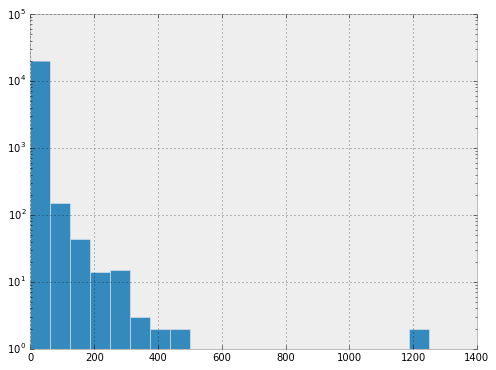

In [11]:
train_samp.adjusted_demand.hist(bins=20, log=True)

### Build The model

In [13]:
pois_model = pm.Model()

with pois_model:
    
    var_week_rate = pm.HalfCauchy("var_week_rate", beta=10)
    var_agency_rate = pm.HalfCauchy("var_agency_rate", beta=10)
    var_product_rate = pm.HalfCauchy("var_product_rate", beta=10)
    
    week_rate = pm.HalfNormal("week_rate", sd=var_week_rate, shape=n_weeks)
    agency_rate = pm.HalfNormal("agency_rate", sd=var_agency_rate, shape=n_agencies)
    product_rate = pm.HalfNormal("product_rate", sd=var_product_rate, shape=n_products)
    
    demand_rate = pm.Deterministic("demand_rate", week_rate[week_code] + product_rate[product_code] + agency_rate[agency_code])
    
    adjusted_demand = pm.Poisson("adjusted_demand", mu=demand_rate, observed=train_samp.adjusted_demand)

Applied log-transform to var_week_rate and added transformed var_week_rate_log to model.
Applied log-transform to var_agency_rate and added transformed var_agency_rate_log to model.
Applied log-transform to var_product_rate and added transformed var_product_rate_log to model.
Applied log-transform to week_rate and added transformed week_rate_log to model.
Applied log-transform to agency_rate and added transformed agency_rate_log to model.
Applied log-transform to product_rate and added transformed product_rate_log to model.


In [14]:
pois_model.vars

[var_week_rate_log,
 var_agency_rate_log,
 var_product_rate_log,
 week_rate_log,
 agency_rate_log,
 product_rate_log]

In [15]:
with pois_model:
    advi_fit = pm.advi(n=10000)

Iteration 0 [0%]: ELBO = -488203.41
Iteration 1000 [10%]: Average ELBO = -502945.4
Iteration 2000 [20%]: Average ELBO = -341911.87
Iteration 3000 [30%]: Average ELBO = -249047.95
Iteration 4000 [40%]: Average ELBO = -188041.91
Iteration 5000 [50%]: Average ELBO = -150658.68
Iteration 6000 [60%]: Average ELBO = -128008.11
Iteration 7000 [70%]: Average ELBO = -114510.37
Iteration 8000 [80%]: Average ELBO = -106508.12
Iteration 9000 [90%]: Average ELBO = -101674.41
Finished [100%]: Average ELBO = -98691.27


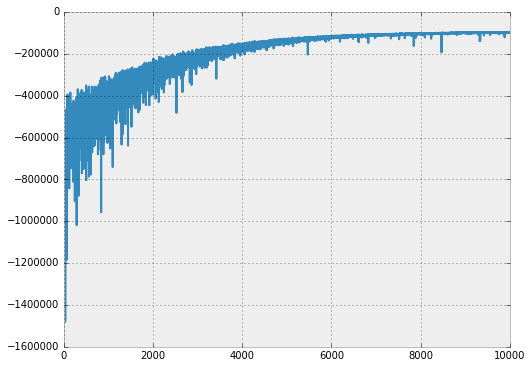

In [16]:
plt.plot(advi_fit.elbo_vals)

In [17]:
np.exp(advi_fit.means["week_rate_log"])

array([ 0.99699551,  1.08432977,  0.91323408,  0.94640915,  0.98768204,
        0.94091305,  0.88762638])

In [18]:
np.exp(advi_fit.stds["week_rate_log"])

array([ 1.26379183,  1.2610218 ,  1.28485144,  1.27697771,  1.26586551,
        1.26867108,  1.27871337])

In [19]:
with pois_model:
    trace_pois = pm.sample_vp(advi_fit, draws=500)

In [20]:
trace_pois["week_rate"].mean(0)

array([ 1.04342373,  1.11789216,  0.93960503,  0.96962508,  1.0238261 ,
        0.96051872,  0.9223246 ])

In [21]:
trace_pois["week_rate"].var(0)

array([ 0.06480538,  0.07296269,  0.05768922,  0.05619647,  0.0611392 ,
        0.05202479,  0.05412337])

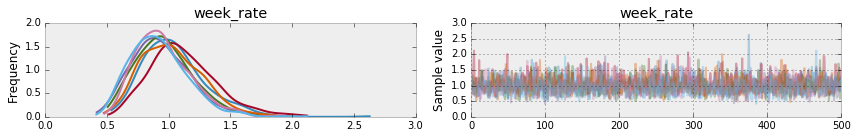

In [22]:
_ = pm.traceplot(trace_pois, varnames=["week_rate"])

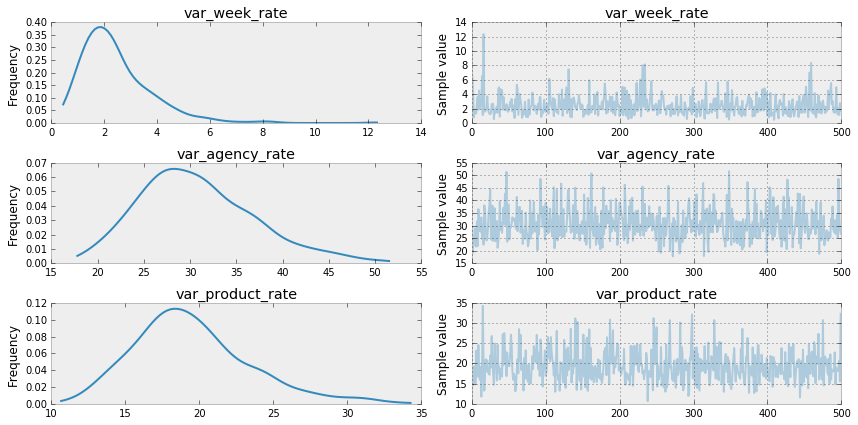

In [42]:
_ = pm.traceplot(trace_pois, varnames=["var_week_rate","var_agency_rate","var_product_rate"])

In [26]:
with pois_model:
    ppc = pm.sample_ppc(trace_pois, samples=100)

In [27]:
ppc_adj_demand = ppc["adjusted_demand"]

In [28]:
train_samp.adjusted_demand.describe()

count    20000.000000
mean         7.439350
std         22.302163
min          0.000000
25%          2.000000
50%          3.000000
75%          6.000000
max       1250.000000
Name: adjusted_demand, dtype: float64

In [29]:
pd.Series(np.median(ppc_adj_demand,0)).describe()

count    20000.000000
mean         6.940525
std          9.664920
min          2.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        179.000000
dtype: float64

In [30]:
pd.Series(np.mean(ppc_adj_demand,0)).describe()

count    20000.000000
mean         7.285336
std         10.848590
min          1.880000
25%          3.300000
50%          4.600000
75%          7.080000
max        315.660000
dtype: float64

### Error metrics

#### Root Mean Squared Logarithmic Error

$\epsilon$ = $\sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(p_i + 1) - \log(a_i + 1))^2}$

Ref: https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError

In [31]:
from utils import rmsle

In [32]:
errors = np.array([rmsle(train_samp.adjusted_demand.values, s) for s in ppc_adj_demand])

In [33]:
np.mean(errors)

0.80897848925174243

In [34]:
rmsle(train_samp.adjusted_demand.values, np.mean(ppc_adj_demand, axis=0))

0.70448984269180093

In [35]:
np.median(errors)

0.80889005832025662

In [36]:
rmsle(train_samp.adjusted_demand.values, np.median(ppc_adj_demand, axis=0))

0.69309281100510967

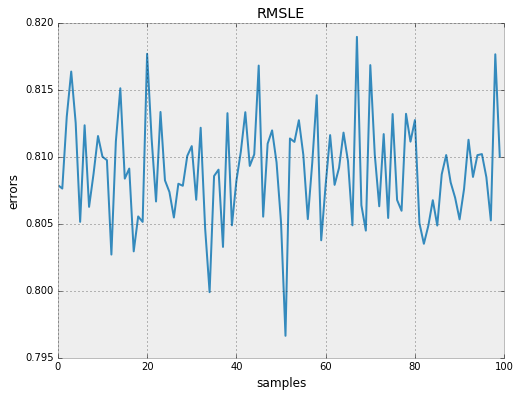

In [37]:
plt.plot(errors)
plt.title("RMSLE")
plt.xlabel("samples")
plt.ylabel("errors")

In [38]:
print("Best error: {:.3f}".format(errors[np.argmin(errors)]))

Best error: 0.797


In [39]:
def plot_ppc(ppc_var, name="median"):
    funs = {"mean":np.mean, "median":np.median}
    f = funs[name]
    n_samp = ppc_var.shape[0]
    fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)

    axs[0].hist(train_samp.adjusted_demand, bins=20, log=True)
    axs[0].set_title("Observed data")

    axs[1].hist(f(ppc_var, axis=0), bins=20)
    axs[1].set_title("Posterior %s (%d samples)" % (name, n_samp))

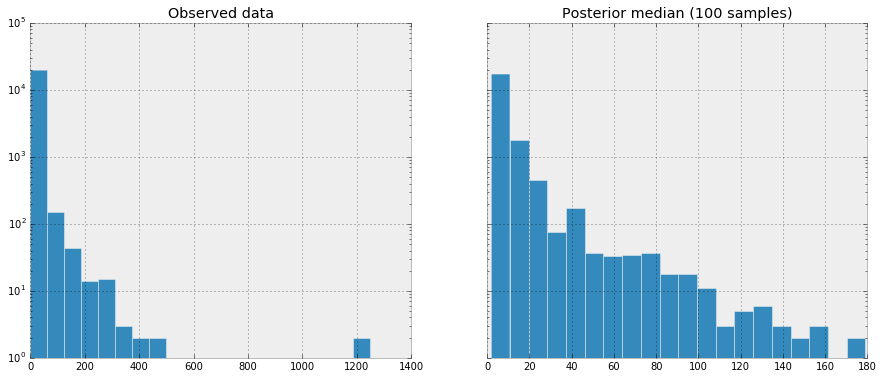

In [40]:
plot_ppc(ppc_adj_demand)

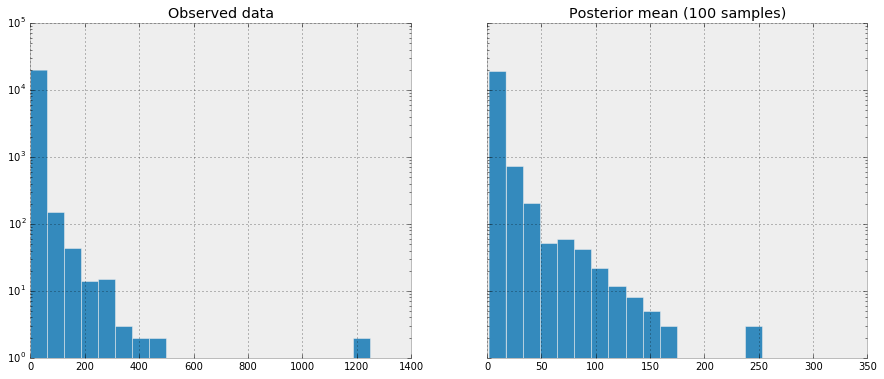

In [41]:
plot_ppc(ppc_adj_demand, name="mean")